<div style="font-family:verdana; 
            word-spacing:1.5px; 
            display:fill; 
            background-color:#E3F8FF;
            border-radius:5px;
            padding:5px 5px 5px 5px;
            text-align:center;">
    <b style="font-size:32px;">Flower Recognition</b>
    <div style="font-size:16px;">Multi-Class Image Classification</div>
</div>

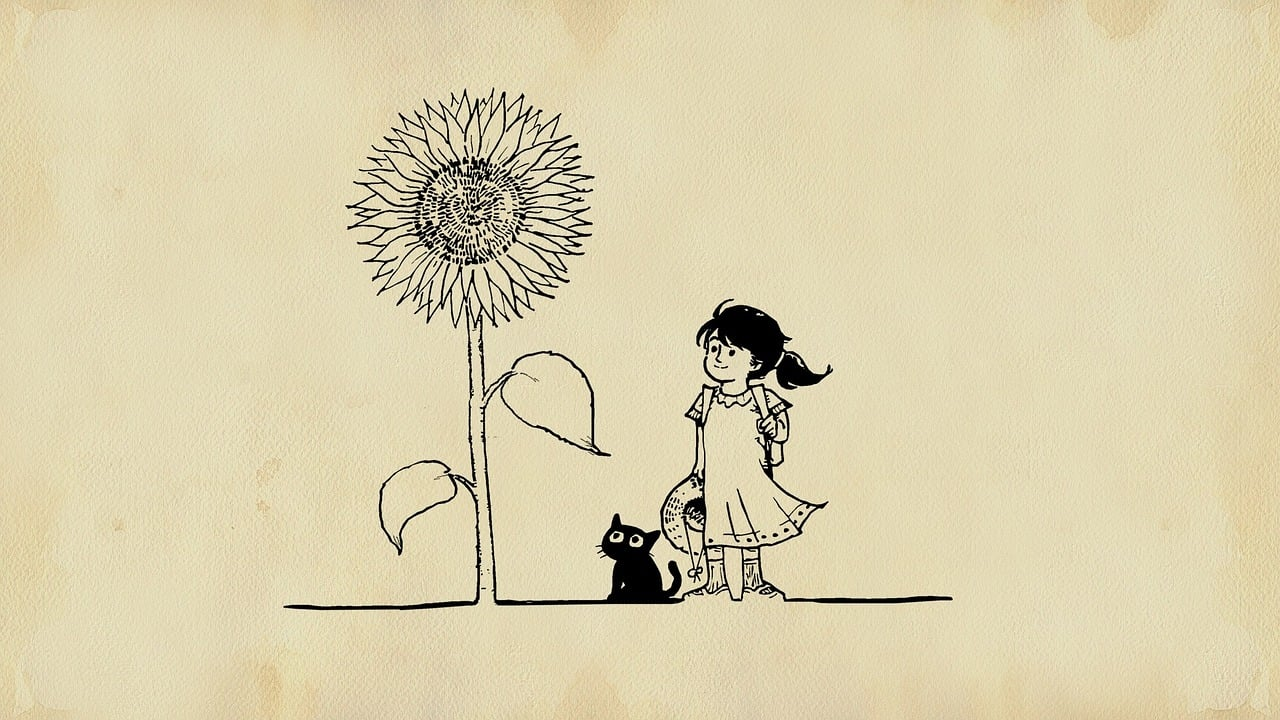

<cite>Photo by [rawpixel](https://dribbble.com/rawpixel)</cite>

<div style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#F1FFD9;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;
   margin:5px;">
    <h1>Summary of Dataset and Model Configurations</h1>
    <ul>
        <li><b>ML Task:</b> Multi-Class Image Classification</li>
        <li><b>Data Source:</b> Flower Recognition from Kaggle</li>
        <li><b>Features:</b> PIL Images on RGB mode</li>
        <li><b>Labels:</b><code>{'0': 'dandelion', '1': 'daisy', '2': 'sunflower', '3': 'tulip', '4': 'rose'}</code></li>
        <li><b>Transformation Methods:</b> image augmentations, tensor normalization</li>
        <li><b>Model:</b> Pretrained with ResNet50</li>
        <li><b>Evaluation Metrics:</b> plotting losses and accuracy values from training and validation sets</li>
        <li><b>Hyperparameter Settings:</b> 
            <ul>
                <li><b>criterion:</b> nn.CrossEntropyLoss()</li>
                <li><b>optimizer:</b> optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)</li>
                <li><b>exp_lr_scheduler:</b> lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)</li>
                <li><b>num_epochs:</b> 25</li>
            </ul>
        </li>
    </ul>
</div>
<div style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#99DDCC;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <h1>Summary of Model Performance</h1>
    <ul>
        <li><b>Last training values (at epoch 24):</b> loss 0.0744, acc: 0.9794
        <li><b>Last valididation values (at epoch 24):</b> loss: 0.1761, acc: 0.9374 </li>
        <li><b>Best validation accuracy:</b> 0.955916</li>
        <li><b>Time it took to train:</b> 18m 46s</li>
        <li><b>Without early stopping:</b> Loss values and accuracy rates didn't seem to improve much after Epoch 8-10 </li>
    </ul>
    <b>Check out the predictions made at the bottom :D</b>    
</div>

***

<div style="font-size:32px; padding:20px; text-align:center; display:fill; border-radius:15px 15px 0px 0px; background-color:#A5BFDD;">
    <b>Table of Contents</b>
</div>
<div style="background-color:#A5BFDD; padding:30px; font-size:15px; border-radius:0px 0px 15px 15px; font-family: verdana;">
    
* [Import & Install](#iid)    
* [1. Exploratory Data Analysis (EDA)](#1)
    * [1.1 Check General Dataset Info](#1.1)
    * [1.2 Analyze Image Properties](#1.2)
    * [1.3 Analyze Class Distributions](#1.3)
    * [1.4 Analyze Pixel Value Distributions (RGB & Tensor Images)](#1.4)
* [2. Data Preparation](#2)
    * [2.1 Create Custom Dataset Class](#2.1)
    * [2.2 Create Label-to-Index Dictionary](#2.2)
    * [2.3 Normalizing Image Tensor Values w/ Mean=0, Standard Deviation=1](#2.3)
    * [2.4 Calculate Actual Mean and Standard Deviation of Dataset](#2.4)
    * [2.5 Normalize Image Tensor Values w/ Calculated Mean and Standard Deviation](#2.5)
    * [2.6 Split Dataset](#2.6)
* [3. Model Building](#3)
    * [3.1 Configure GPU Use](#3.1)
    * [3.2 Choose a Pretrained Model](#3.2)
    * [3.3 Load Pretrained Model onto GPU Device](#3.3)
* [4. Model Training](#4)
    * [4.1 Set Hyperparameters](#4.1)
    * [4.2 Define ML Training Helper Functions](#4.2)
    * [4.3 Time to Train!](#4.3)
* [5. Model Evaluation](#5)
    * [5.1 Plot Model Performance Metrics](#5.1)
    * [5.2 Model Predictions](#5.2)
* [6. Conclusion](#6)
    
</div>

<div id="iid" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#B2DFFB;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
   <p style="font-size:24px;">Import & Install </p>
</div>    

<div style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#D3F4FF;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Import Dependencies</p>
</div>

In [1]:
import pandas as pd
import numpy as np
import os
import time

import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader

# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

# setup backend for matplotlibs plots
%matplotlib inline

In [2]:
import gc 

def report_gpu(): 
    print(torch.cuda.list_gpu_processes()) 
    gc.collect() 
    torch.cuda.empty_cache()

<div style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#D3F4FF;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Import Data</p>
</div>

In [3]:
# create empty list for images and labels
images_list = []
labels_list = []

# gather images and labels into respective lists
data_dir = '/kaggle/input/flowers-recognition/flowers/'
for root, dirs, files in os.walk(data_dir):
    for name in files:
        full_path = os.path.join(root, name)
        label = full_path.split('/')[-2]
        images_list.append(full_path)
        labels_list.append(label)

In [4]:
# zip the Lists into a DataFrame
df = pd.DataFrame(list(zip(images_list, labels_list)), columns = ["images", "labels"])
df.head()

images     labels
0  /kaggle/input/flowers-recognition/flowers/dand...  dandelion
1  /kaggle/input/flowers-recognition/flowers/dand...  dandelion
2  /kaggle/input/flowers-recognition/flowers/dand...  dandelion
3  /kaggle/input/flowers-recognition/flowers/dand...  dandelion
4  /kaggle/input/flowers-recognition/flowers/dand...  dandelion

<div id="1" style="color:black;
   display:fill;
   border-style:solid;
   border-width:5px;
   border-radius:5px;
   border-color:#DF2E38;
   background-color:#FF8080;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <div>
        <p style="font-size:24px;">Exploratory Data Analysis (EDA): </p>
        <p>The purpose of conducting EDA on the dataset is to gain a general understanding of what the dataset is comprised of, and what may need cleaning or manipulating prior to feeding it as input into the ML model. Since this is an multi-class image classification ML task, here are the following properties checked in the EDA process: </p>
        <ul>
            <li>Sample size</li>
            <li>Image features (e.g. dtype, RGB mode, sizing, etc.)</li>
            <li>Class labels</li>
            <li>Class distribution of images (e.g. how many images are there in each class?)</li>
            <li>Pixel value distribution of a random PIL Image</li>
        </ul>
        <p style="font-size:16px;">Takeaways:</p>
        <ul style="font-size:12px; line-height:1.7em font-family:verdana;">
          <li>Small dataset <code>n &lt; 5000</code></li>
          <li>5 label classes: <code>{'0': 'dandelion', '1': 'daisy', '2': 'sunflower', '3': 'tulip', '4': 'rose'}</code></li>
          <li>Image in PIL format, in RGB mode, and have inconsistent sizing</li>
          <li>Pixel value distributions are heavily skewed for each picture</li> 
          <li>No invalid PIL images</li>
          <li>No duplicate images</li>
          <li>Classes are not equal, but not too imbalanced</li>
        </ul>
    </div>
</div>

***

<div id="1.1" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FFE5E5;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Check General Dataset Info</p>
    <p> Doing a general check of dataset is essential in understanding what characteristics and properties this dataset comprises of, and how we can potentially clean or tranform them to best fit the ML task objective. In our case, the flower recognition dataset is comprised of subfolders labeled with flower names, and each subfolder contains PNG images only. We want to know what about these PNG images we're capable of cleaning, manipulating, preprocessing. That way, our model is fed with clean, consistent data information, which helps its training performance.</p>
    <p><u>Steps to check for general info</u>:</p>
    <ol>
        <li>Call <code>.info()</code> to get the sample size, data types, etc.</li>
        <li>Get the number of labels in the dataset</li>
    </ol>
<div>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4317 entries, 0 to 4316
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  4317 non-null   object
 1   labels  4317 non-null   object
dtypes: object(2)
memory usage: 67.6+ KB


In [6]:
df['labels'].unique()

array(['dandelion', 'daisy', 'sunflower', 'tulip', 'rose'], dtype=object)

<div id="1.2" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FFE5E5;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Analyze Image Properties</p>
    <p>Assessing image properties helps us determine what data type, color mode, or image sizing needs to be cleaned and processed prior to training. This ensures data consistency throughout all input being fed into the model. </p>
    <p><u>Steps to Analyze Image Properties</u>:</p>
    <ol>
        <li>Sample a few random images</li>
        <li>Print out the images properties</li>
        <li>Plot the random images</li>
    </ol>
<div>

In [7]:
from io import BytesIO
import requests
from PIL import Image

random_samples_df = df.sample(n=16)
random_samples_df = random_samples_df.reset_index(drop=True)
print(random_samples_df['images'][0])
random_samples_df.head()

/kaggle/input/flowers-recognition/flowers/dandelion/5605093210_5fecb71c61.jpg


images     labels
0  /kaggle/input/flowers-recognition/flowers/dand...  dandelion
1  /kaggle/input/flowers-recognition/flowers/dand...  dandelion
2  /kaggle/input/flowers-recognition/flowers/tuli...      tulip
3  /kaggle/input/flowers-recognition/flowers/dais...      daisy
4  /kaggle/input/flowers-recognition/flowers/dais...      daisy

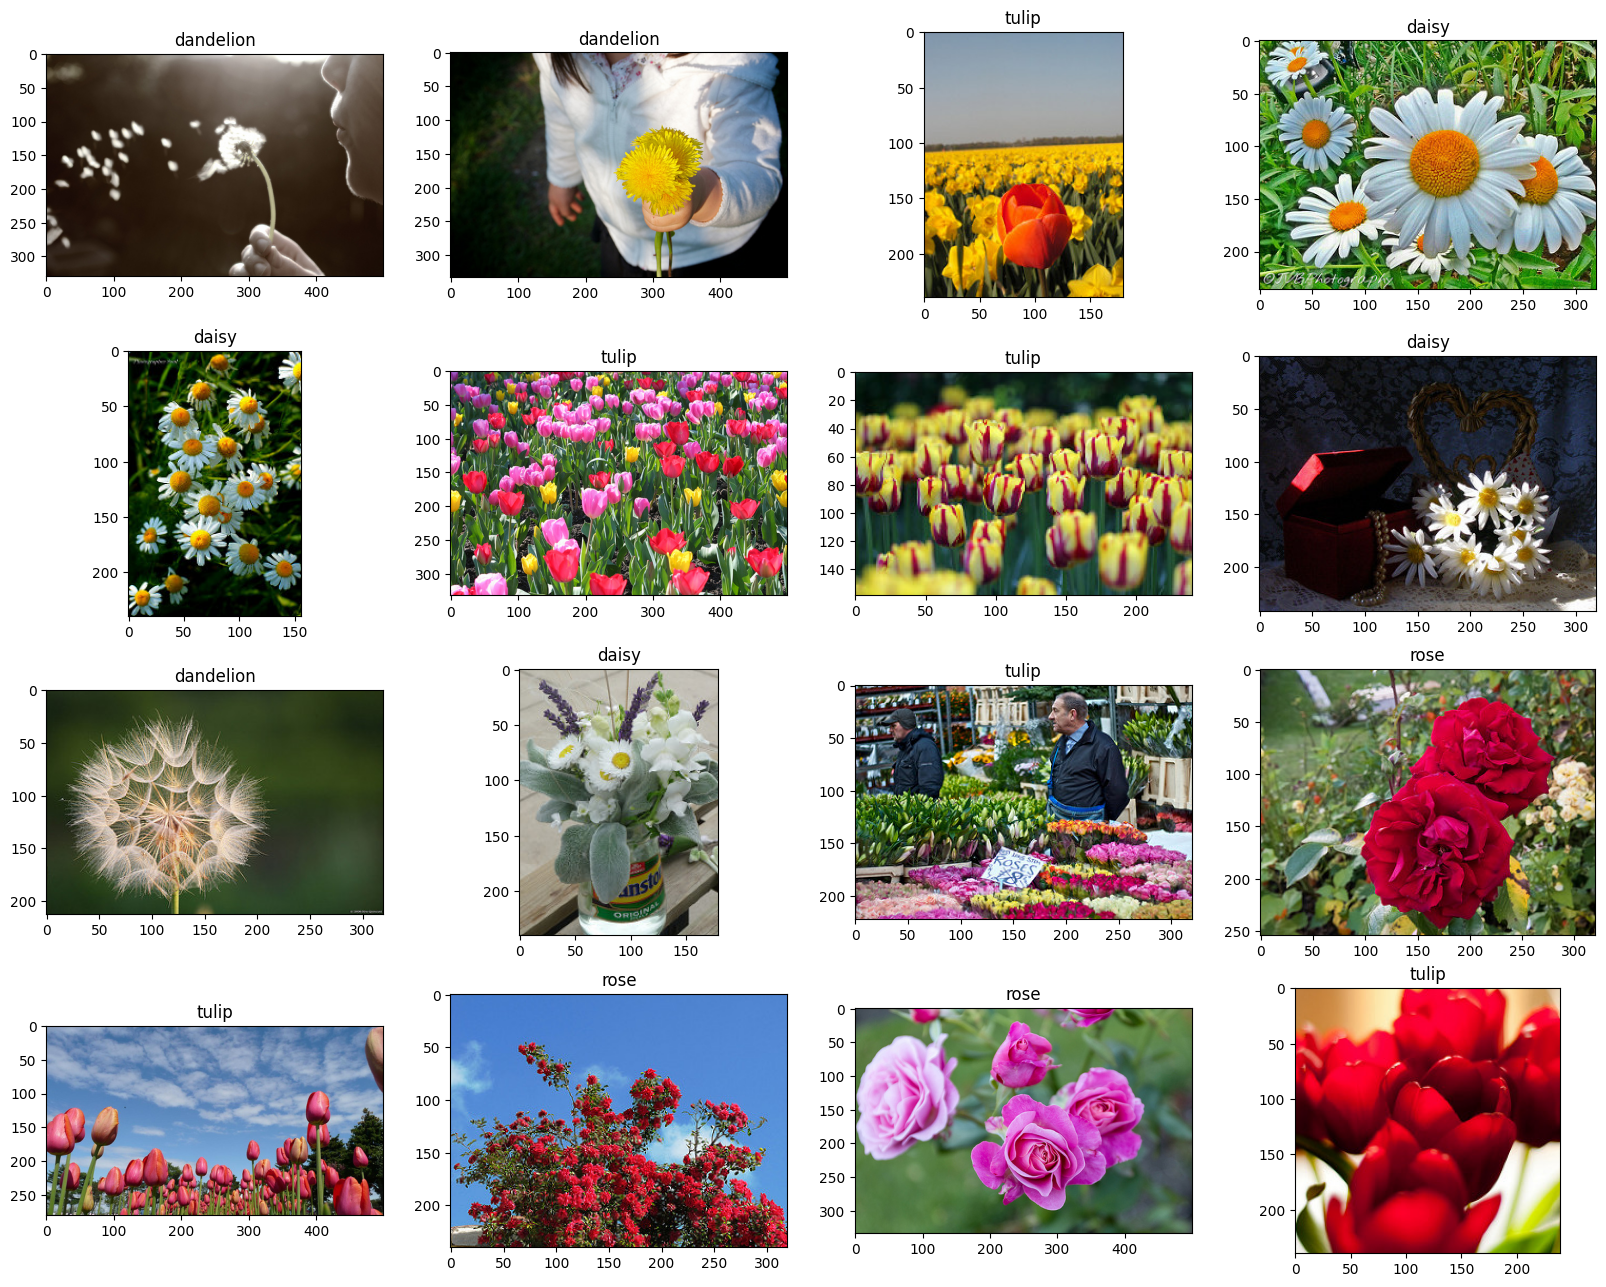

In [8]:
plt.figure(figsize=(20, 20))
columns = 4

for index, row in random_samples_df.iterrows():
    plt.subplot(len(random_samples_df) // columns + 1, columns, index + 1)
    image = plt.imread(row['images'])
    plt.imshow(image)
    plt.title(row["labels"])
    
plt.show()

<div id="1.3" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FFE5E5;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Analyze Class Distribution</p>
    <p>Analyzing class distributions provides with regards to how imbalanced classes are in relation to each other. Should there be heavy class imbalance (e.g. 5000+ more images of roses than there are tulips), this information is worth addressing in the data processing phase (e.g. generate augmented images to compensate for the low samples of a particular class) prior to training. </p>
    <p><u>Steps for Analyze Class Distribution</u>:</p>
    <ol>
        <li>Group the images by label name, and get the count for each label</li>
        <li>Plot a bar graph showcasing the count of images per label</li>
    </ol>
<div>

           images
labels           
daisy         764
dandelion    1052
rose          784
sunflower     733
tulip         984


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'daisy'),
  Text(1, 0, 'dandelion'),
  Text(2, 0, 'rose'),
  Text(3, 0, 'sunflower'),
  Text(4, 0, 'tulip')])

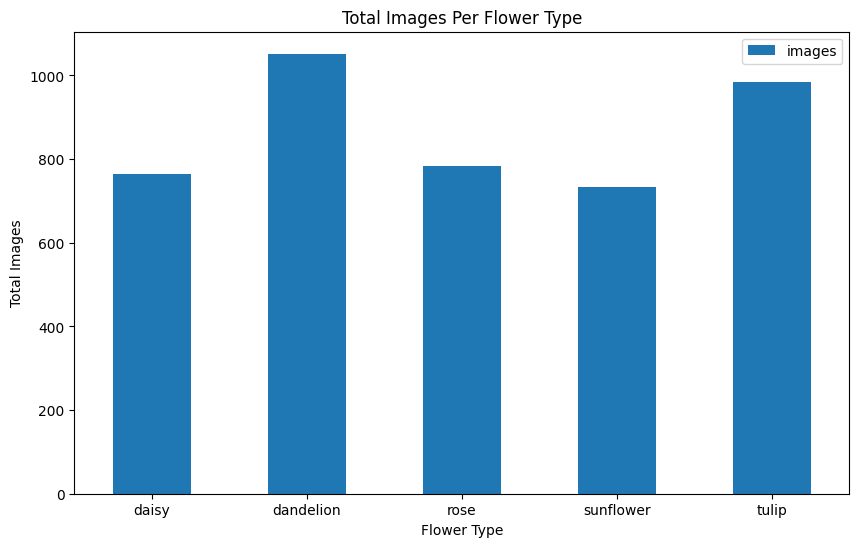

In [9]:
df_groups = df.groupby(['labels']).count()
print(df_groups)
df_groups.plot(kind="bar", 
               title="Total Images Per Flower Type", 
               ylabel="Total Images", 
               xlabel="Flower Type", 
               figsize=(10, 6))
plt.xticks(rotation=0)

<div id="1.4" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FFE5E5;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Analyze Pixel Values Distribution (as an RGB Image and Tensor Image)</p>
    <p>The purpose of analyzing the distribution of an image's pixel values is to get an idea of the range of pixel intensity values, and how to normalize the image pixel values. Should be there heavy skews, it's important to scale images to be of similar image intensity and texture instances. This is all in an effort to help the ML model notice similar feature values throughout its learning process. </p>
    <p><u>Steps for each Image Type (RGB and Tensor)</u>:</p>
    <ol>
        <li>Sample for a random image</li>
        <li>Read the image</li>
        <li>Convert the PIL image into an array</li>
        <li>Plot a histogram of the that sampled image's pixel values</li>
    </ol>
<div>

In [10]:
# sample for a random image, and read the image

random_image = df.sample()
image = Image.open(row['images'])

Text(0.5, 1.0, 'Distribution of Pixels (as an RGB Image)')

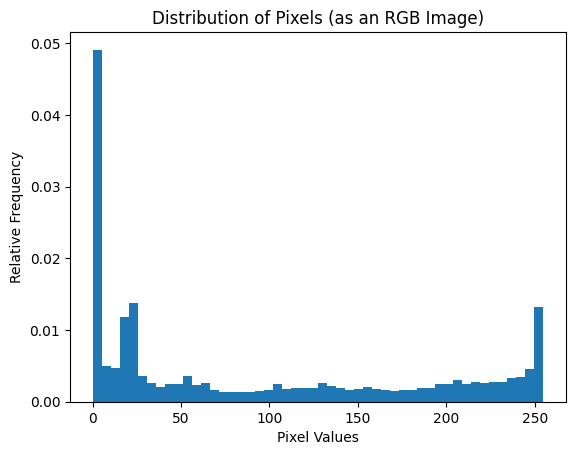

In [11]:
# RGB Image

image_arr = np.array(image) 

plt.hist(image_arr.ravel(), bins=50, density=True)
plt.xlabel("Pixel Values")
plt.ylabel("Relative Frequency")
plt.title("Distribution of Pixels (as an RGB Image)")

Text(0.5, 1.0, 'Distribution of Pixels (as a Tensor Image)')

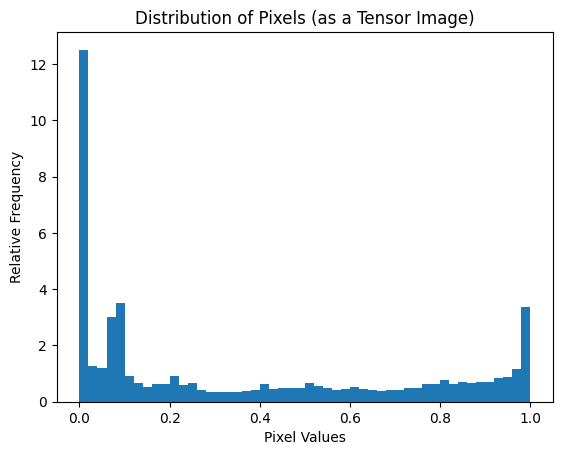

In [12]:
# Tensor Image

to_tensor_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])
image_transform = to_tensor_transform(image)
image_tensor_arr = np.array(image_transform)

plt.hist(image_tensor_arr.ravel(), bins=50, density=True)
plt.xlabel("Pixel Values")
plt.ylabel("Relative Frequency")
plt.title("Distribution of Pixels (as a Tensor Image)")

<div id="2" style="color:black;
   display:fill;
   border-width: 5px;
   border-style:solid;
   border-radius:5px;
   border-color:#2FDD92;
   background-color:#97DBAE;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:24px; padding:5px 5px 5px 5px;"><b>Data Preparation</b></p>
    <p>Now that we have a general idea of what the dataset looks like, and what concerns we may have about the data, this portion of the ML process ensures that we address those concerns, and clean and transform well enough to be fed into the ML model as input. By the end of this section, we want to have a dataset that houses clean and consistent data values. Some of the processes to ensure this objective include:</p>
    <ul>
        <li>Converting PIL images to tensors</li>
        <li>Label Encoding</li>
        <li>Finding aggregate mean and standard deviation</li>
        <li>Normalizing pixel image values with the aggregate mean and standard deviation</li>
        <li>Augmenting images by applying pytorch image transformations</li>
        <li>Splitting the dataset</li>
        <li>Instantiating the cleaned dataset as Pytorch's Dataset and DataLoader object</li>
    </ul>
    <p style="font-size:16px;">Takeaways:</p>
    <ul>
        <li>Transformed the dataset into the resultant form: Tuple[Tensor, Int]</li>
        <li>Doubled the sample size by adding generated augmented images. </li>
    </ul>
</div>

<div id="2.1" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E1F0DA;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Create Custom Dataset Class</p>
    <p>In order to keep all data sample formatting and distribution as consistent as possible (e.g. same image size, same image data type, encode labels, etc.), creating a custom dataset class gives us more leeway in modifying how we want to resolve class imbalance, image transformation properties, or even structure our dataset.
    <p><u>Steps to create custom dataset class</u>:</p>
    <ol>
        <li>Defining <code>__init__()</code><code>__len__()</code><code>__getitem__()</code></li>
    </ol>
<div>

In [13]:
class FlowerRecognitionDataset(Dataset):
    def __init__(self, df, class_list, transform=None):
        self.df = df
        self.transform = transform
        self.class_list = class_list

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image = Image.open(self.df.loc[index, "images"])
        label = self.class_list.index(self.df.loc[index, 'labels'])
        if self.transform:
            image = self.transform(image)
        return image, label

<div id="2.2" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E1F0DA;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Create A Label-to-Index Dictionary</p>
    <p> </p>
    <p><u>Steps to associate class labels to encoded labels</u>:</p>
    <ol>
        <li>Create a list of class labels</li>
        <li>Create an empty map</li>
        <li>enumerate through the list of class labels, and map the index of the list as the key, and the string of the class label as the value.</li>
    </ol>
<div>

In [14]:
class_labels = list(df['labels'].unique())
class_labels_map = {}
for indx, label in enumerate(class_labels):
    class_labels_map[str(indx)] = label

In [15]:
class_labels_map

{'0': 'dandelion', '1': 'daisy', '2': 'sunflower', '3': 'tulip', '4': 'rose'}

<div id="2.3" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E1F0DA;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Normalizing Orginal Images' Tensor Values w/ Default Mean=0, Standard Deviation=1</p>
    <p>In order to find the aggregate mean and standard deviation of the dataset, we'd have to create a temporary dataset, and apply default image transformations on it (mean = 0, standard deviation = 1).</p>
    <p><u>Steps to calculate mean and standard deviation</u>:</p>
    <ol>
        <li>Define the image transforms for the original dataset</li>
        <li>Create a Pytorch dataset with the final cleaned dataset, and apply default image transforms </li>
        <li>Create a dataloader from the created dataset</li>
    </ol>
<div>

In [16]:
SIZE=224

transform_to_tensor = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((SIZE, SIZE)),
    v2.RandomResizedCrop(224, scale=(0.9, 1.0)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0, 0, 0], std=[1, 1, 1]) # use as default values for now, will adjust later.
])

In [17]:
# create dataset and dataloader instance of the dataset

flower_ds = FlowerRecognitionDataset(df, class_list = tuple(df['labels'].unique()), transform=transform_to_tensor)
flower_dl = DataLoader(flower_ds, batch_size=10, shuffle=True)

<div id="2.4" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E1F0DA;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Calculate Mean and Standard Deviation</p>
    <p>The intention behind calculating the mean and standard deviation of the entire dataset is to get a sense of where most pixel values are, and how spread out those values are. This is all in an effort to normalize these values with the mean and standard deviation acting as a baseline factor.</p>
    <p><u>Steps to calculate mean and standard deviation</u>:</p>
    <ol>
        <li>Create placeholder tensor values for mean and variance</li>
        <li>loop through all the images and aggregate the sum and the variance from the 0, 2, and 3 axis, </li>
        <li>compute the count of pixels</li>
        <li>compute total mean, total variance, and total standard deviation</li>
    </ol>
<div>

In [18]:
# compute mean and standard deviation of the dataset

from tqdm import tqdm
# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, labels in tqdm(flower_dl):
    psum += inputs.sum(axis=[0, 2, 3]) 
    psum_sq += (inputs**2).sum(axis=[0, 2, 3])

  0%|          | 0/432 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 432/432 [00:44<00:00,  9.78it/s]


In [19]:
# pixel count
count = len(df) * SIZE * SIZE

# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

# output
print("mean: " + str(total_mean))
print("std:  " + str(total_std))

mean: tensor([0.4635, 0.4224, 0.3014])
std:  tensor([0.2928, 0.2622, 0.2853])


<div id="2.5" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E1F0DA;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Normalize Image Tensors w/ Computed Mean and Standard Deviation</p>
    <p>Now that we have the aggregate mean and standard deviation of the dataset, we can apply these values to our image transformations. This is helpful in normalizing our images appropriately, rather than using the default weights from ImageNet. </p>
    <p><u>Steps to normalize tensor values</u>:</p>
    <ol>
        <li>update image transformation variable with the computed mean and standard deviation</li>
        <li>add another image tranformation specifically to augment images</li>
        <li>Create original and aumented dataset</li>
        <li>Concatenate the two datasets into one</li>
    </ol>
<div>


In [20]:
SIZE=224

image_transforms = v2.Compose([
       v2.PILToTensor(),
       v2.RandomRotation(degrees=5),
       v2.Resize((SIZE, SIZE)),
       v2.RandomResizedCrop(224, scale=(0.9, 1.0)),
       v2.RandomHorizontalFlip(),                                                 
       v2.ColorJitter(brightness=.1, hue=.1),
       v2.ToDtype(torch.float32, scale=True),
       v2.Normalize(mean=total_mean, std=total_std)
])

In [21]:
flower_ds = FlowerRecognitionDataset(df, class_list = tuple(df['labels'].unique()), transform=image_transforms)

<div id="2.6" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E1F0DA;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Split Dataset</p>
    <p>It is by convention that we split our datasets into train, validation, and test sets prior to training the model. This is imperative in order to assess the model's performance with a portion of the dataset that the model hasn't been trained on (e.g. val and test sets).</p>
    <ol>
        <li>Calculate the validation dataset size</li>
        <li>Calculate the train dataset size</li>
        <li>Create the train dataset and validation set with Pytorch's random_split function.</li>
        <li>Create separate dataloaders for the train and validation dataset</li>
    </ol>
<div>

In [22]:
val_pct = 0.1
val_size = int(val_pct * len(flower_ds))

train_size = len(flower_ds) - val_size

print("Train dataset size: ", train_size)
print("Validation dataset size: ", val_size)

Train dataset size:  3886
Validation dataset size:  431


In [23]:
train_ds, valid_ds = random_split(flower_ds, (train_size, val_size))

len(train_ds), len(valid_ds)

(3886, 431)

In [24]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [25]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; <b>To Prevent Memory Leaks + Clean-up Storage Space Before Proceeding:</b>
It's important to not let previous variables made in prior sections (e.g. EDA) to fill up storage space, so please clean up unused variables prior to training. This is helpful in case we want to download models, pytorch, or download performance metrics that may take up some space.
</div>

In [26]:
## Prevent Memory Leaks + Cleanup Storage

# Examples below:
# del df_groups
# del random_samples_df


<div style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E1F0DA;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Final Look at Images from DataLoader</p>
<div>

In [27]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

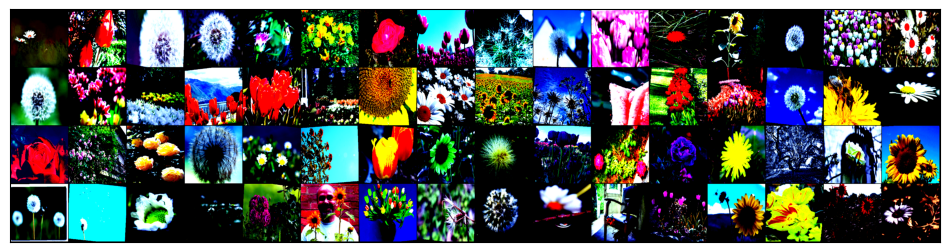

In [28]:
show_batch(train_dl)

<div id="3" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FFB319;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:24px; padding:5px 5px 5px 5px;"><b>Model Building</b></p>
    <p>With the data cleaned, transformed, and split, it's now ready to be fed into some ML model, but what kind of model? The purpose of this section is to build a model (with useful embedded layers) that will parse out feature patterns from the input data (e.g. images), that can help it determine what images are of a particular flower type. Some of the processes done to fulfill this object are:</p>
    <ul>
        <li>Choosing a pretrained model</li>
        <li>Load the pretrained model from Pytorch</li>
        <li>Modifying the pretrained model's FC layer</li>
        <li>Configure use of GPUs (single/multiple)</li>
        <li>Create Training Utility Functions</li>
        ----------<b>Adjust the following iteratively (if needed) when fine-tuning models</b>-----------
        <li>Setting Hyperparameters (learning rate, optimizers, weight decay)</li>
        <li>Choosing/customizing a loss function</li>
        <li>Freezing full/partial network</li>
        <li>Define model floating-point precision (for more precise computation during training)</li>
    </ul>
    <p>Takeaways: </p>
    <ul>
        <li>Using ResNet50, and modifying the fully-connected (FC) layer to use the number of classes relevant to our dataset</li>
        <li>Apply early stopping on the train loop (to decrease unnecessary training time)</li>
        <li>Don't add too much fluff when assessing the baseline performance of the ML task for the first time. After getting the baseline performance metrics, we can then gradually fine-tune the hyperparameters and the pretrained model layers until we have a model that fulfills our objectives. </li>
    </ul>
</div>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; <b>For fine-tuning in future training iterations:</b>
In addition to adding custom layers, custom loss functions as part of the model building, freezing full/partial networks should only be considered when finetuning a model. Since this is our first run, we don't want to add to many fluff to the training unless its current model performance benefits from a change in the model. 
</div>

<div id="3.1" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FAEF9B;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Configure GPU use (single/multiple GPUs for training)</p>
    <p>Why is it important to configure this?</p>
    <ol>
        <li>Create a class to yield a batch of input tensors over to the GPUs available</li>
        <li>Get the device that the model will be training the model on (CPU or GPU)</li>
        <li>Create a device data loader for the train and validation dataloaders</li>
    </ol>
<div>

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
torch.cuda.is_available()
device = get_default_device()

train_device_dl = DeviceDataLoader(train_dl, device)
valid_device_dl = DeviceDataLoader(valid_dl, device)

<div id="3.2" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FAEF9B;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Choosing a Pretrained Model</p>
    <p>The purpose of using a pretrained model is to leverage a model that has the appropriate architecture to satify our ML training objective, and use its weights in our own training model. Using the weights from a pretrained model lessens our training time. </p>
    <p>Steps to fulfill objective: </p>
    <ol>
        <li>Understand the architecture of ResNet50.</li>
        <li>Create a class for ResNet50, for this particular ML task.</li>
    </ol>
<div>

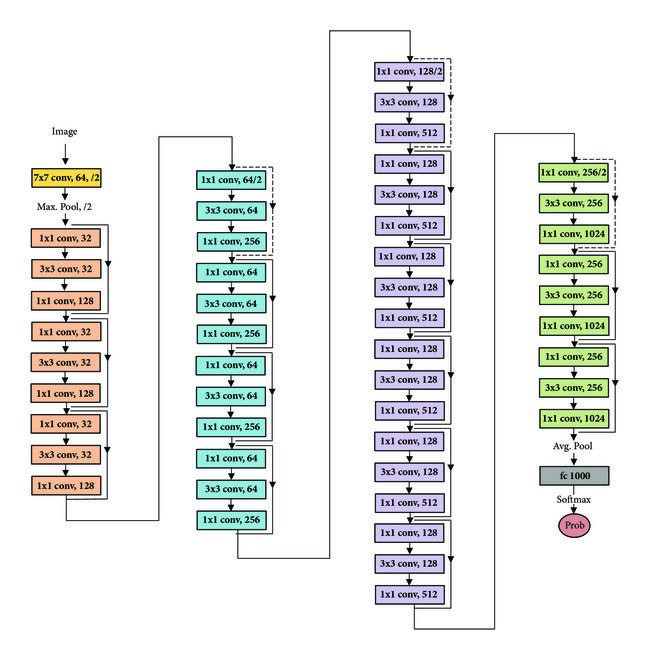

According to this article from [datagen](https://datagen.tech/guides/computer-vision/resnet-50/), the ResNet50 architecture consists of: 48 convolutional layers, 1 max pooling layer, and 1 average pool layer. The 50-layer uses a bottleneck design for the building block, which reduces the number of parameters and matrix multiplications. This enables faster training of each layer. I also chose ResNet50 because its deep hierarchy of layers can extract/identify image features better, and yield higher classification accuracy. 

<div id="3.3" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#FAEF9B;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Loading the Pretrained Model from Pytorch</p>
    <p>The purpose of loading a pretrained model is to utilize their pre-trained weights in order to enhance the performance of learning to classify this new ML task. In order to fully have this pretrained model adapt to learning this particular ML task, we have to modify the FC layer.</p>
    <p>Steps to fulfill objective:</p>
    <ol>
        <li>Load the pretrained model from torchvision</li>
        <li>Modifying the FC layer</li>
        <li>Yield pretrained model to load on GPU device</li>
    </ol>
<div>

In [31]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory
import time

num_classes = 5

# load pretrained model
resnet50 = models.resnet50(weights='IMAGENET1K_V1')

# modify FC layer
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, num_classes)

# yield pretrained model to GPU device
resnet50 = to_device(resnet50, device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


<div id="4" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#91C8E4;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:24px; padding:5px 5px 5px 5px;"><b>Model Training</b></p>
    <p>Now that the pretrained model is loaded, and we've modified the FC layer, it's now time to define the training loop that's meant to iterate through the data, calculate loss, do backpropagation (only if it's iterating through the training data), update the weights, and repeat! Here is a general overview of the steps taken to fulfill this objective: </p>
    <ul>
        <li>Load the pretrained ResNet50 model to the accessed GPU device</li>
        <li>Add utility functions to break down the main components of the <code>train()</code> into more readable functions</li>
        <li>Execute the main <code>train()</code> function to start training!</li>
    </ul>
    <p>Takeaways:</p>
    <ul>
        <li>Last training values (at epoch 24): loss 0.0744 acc: 0.9794
        <li>Last valididation values (at epoch 24): loss: 0.1761 acc: 0.9374 </li>
        <li>Best validation accuracy: 0.955916</li>
        <li>Time it took to train: 18m 46s</li>
        <li>Training doesn't seem to improve much after Epoch 8-10</li>
    </ul>
</div>

<div id="4.1" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#DDF2FD;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Set Hyperparameters</p>
    <p>Steps to fulfill objective:</p>
    <ol>
        <li>Choose a loss function</li>
        <li>Choose an optimizer</li>
        <li>Create a learning rate scheduler</li>
        <li>Set epoch num</li>
    </ol>
<div>

In [32]:
# set the hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 25

<div id="4.2" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#DDF2FD;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Define Training Utility Functions</p>
    <p>The training utility functions are meant to help make the conventional ML training for-loop more "readable". I personally like to break chunks of the training process up, and create separate helper functions for them. Then for the actual training, I call them all one by one. This is purely my personal preference, which helps me debug easier. Some people might find my structuring inconvenient, and that's okay! As long as the work is readable/understandable for the creator and viewers of their notebook :D</p>
    <p>Steps to fulfill objective:</p>
    <ol>
        <li>Wrap the train and valid dataloaders into a dictionary</li>
        <li>Wrap the train and valid dataset sizes into a dictionary</li>
        <li>Define helper functions that are to be used in the main training loop:
            <ul>
                <li>calculate loss</li>
                <li>backpropagation</li>
                <li>update weights</li>
                <li>update epoch performance metrics (loss and accuracy)</li>
                <li>training step (for each batch)</li>
            </ul>
        </li>
        <li>Define the main training loop (account for early stopping)</li>
    </ol>
<div>

In [33]:
dataloaders = {
    'train': train_device_dl,
    'valid': valid_device_dl
}

dataset_sizes = { 
    'train': len(train_ds),
    'valid': len(valid_ds)
}

In [34]:
def calculate_loss(inputs, labels, model, criterion):
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    return loss, preds

def backpropagate(phase, loss, optimizer):
    if phase == 'train':
        loss.backward()
        optimizer.step()
    return loss, optimizer

def update_weights(inputs, labels, preds, loss, running_loss, running_corrects):
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    return running_loss, running_corrects

def update_epoch_performance(running_loss, running_corrects, dataset_sizes, phase):
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    return epoch_loss, epoch_acc

def training_step(dataloaders, model, optimizer, criterion, running_loss, running_corrects, phase):
    model.train() if phase == 'train' else model.eval()

    for inputs, labels in dataloaders[phase]:
        optimizer.zero_grad()
    
        with torch.set_grad_enabled(phase == 'train'):
            loss, preds = calculate_loss(inputs, labels, model, criterion)
            loss, optimizer = backpropagate(phase, loss, optimizer)
                    
        running_loss, running_corrects = update_weights(inputs, labels, preds, loss, running_loss, running_corrects)
    return running_loss, running_corrects

In [35]:
def train(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        train_losses_list = []
        valid_losses_list = []
        train_accuracy_list = []
        valid_accuracy_list = []
        
        early_stop_threshold = 12
        best_epoch = 0
        best_acc = 0.0        
        
        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                running_loss, running_corrects = training_step(dataloaders, 
                                                               model, 
                                                               optimizer, 
                                                               criterion, 
                                                               running_loss, 
                                                               running_corrects,
                                                               phase=phase)
                if phase == 'train':
                    scheduler.step()

                epoch_loss, epoch_acc = update_epoch_performance(running_loss, 
                                                                 running_corrects, 
                                                                 dataset_sizes, phase)
                
                train_losses_list.append(epoch_loss) if phase == 'train' else valid_losses_list.append(epoch_loss)
                train_accuracy_list.append(epoch_acc) if phase == 'train' else valid_accuracy_list.append(epoch_acc)
                
                print(f'{phase} phase -- epoch {epoch} / {num_epochs - 1} -- {phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')

                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    # deep copy the model
                    torch.save(model.state_dict(), best_model_params_path)                    
                elif epoch - best_epoch > early_stop_threshold:
                    print("Early stopping: training stopped at epoch %d" % epoch)
                    break  # terminate the training loop

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses_list, valid_losses_list, train_accuracy_list, valid_accuracy_list

<div id="4.3" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#DDF2FD;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px;">Time to Train!</p>
<div>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; Clear cache prior to training!
</div>

In [36]:
torch.cuda.empty_cache()

In [37]:
resnet50, train_losses_list, valid_losses_list, train_accuracy_list, valid_accuracy_list = train(resnet50, 
                                                                                                 criterion, 
                                                                                                 optimizer, 
                                                                                                 exp_lr_scheduler, 
                                                                                                 num_epochs=25)

train phase -- epoch 0 / 24 -- train loss: 0.9412 acc: 0.6770
valid phase -- epoch 0 / 24 -- valid loss: 0.4571 acc: 0.8469

train phase -- epoch 1 / 24 -- train loss: 0.3678 acc: 0.8847
valid phase -- epoch 1 / 24 -- valid loss: 0.3292 acc: 0.8886

train phase -- epoch 2 / 24 -- train loss: 0.2557 acc: 0.9120
valid phase -- epoch 2 / 24 -- valid loss: 0.2833 acc: 0.9072

train phase -- epoch 3 / 24 -- train loss: 0.1967 acc: 0.9352
valid phase -- epoch 3 / 24 -- valid loss: 0.2388 acc: 0.9165

train phase -- epoch 4 / 24 -- train loss: 0.1544 acc: 0.9480
valid phase -- epoch 4 / 24 -- valid loss: 0.2389 acc: 0.9095

train phase -- epoch 5 / 24 -- train loss: 0.1260 acc: 0.9611
valid phase -- epoch 5 / 24 -- valid loss: 0.2428 acc: 0.9304

train phase -- epoch 6 / 24 -- train loss: 0.1070 acc: 0.9665
valid phase -- epoch 6 / 24 -- valid loss: 0.2255 acc: 0.9350

train phase -- epoch 7 / 24 -- train loss: 0.0905 acc: 0.9735
valid phase -- epoch 7 / 24 -- valid loss: 0.2244 acc: 0.9281



<div id="5" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#CABBE9;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:24px; padding:5px 5px 5px 5px;"><b>Model Evaluation</b></p>
    <p>The purpose of this section is to assess how well our model did in learning to classify images, and use this information to iteratively modify our model architecture, dataset components, hyperparameters, etc. Some of the processes done to fulfill this objective includes:</p>
    <ul>
        <li>Plot model accuracy (training vs. validation set</li>
        <li>Plot model losses (training Vs. validation set)</li>
        <li>Show model predictions</li>
    </ul>
    <p style="font-size:16px;">Takeaways</p>
    <ul>
        <li>When initially training with 25 epochs, the train losses and accuracy seem to make steady learning improvements in the first 10 epochs, but results after 10 epochs don't seem to look too meaningful (e.g loss values seem to hover around 0.074 to 0.078, accuracy values seem to hover around 0.978 to 0.980). This possibly hints that early stopping may be helpful in shortening the training time.</li>
        <li>Validation loss and accuracy values did not carve out as noticeable of a curve as those from the training set (see the accuracy and loss plots below). </li>
        <li>From observation, the gap between the training and validation sets' training and accuracy values was not too big. </li>
    </ul>
</div>

<div id="5.1" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E5E0FF;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px; padding:5px 5px 5px 5px;">Plot Model Performance</p>
    <p>Plotting the loss and accuracy curves the training and validation sets should give us an idea of how consistent the model in learning to classify images throughout training. It should also give us an indication of whether there is overfitting, unfitting, or whether the number of epochs originally set for training was too little or too high. All of this information is helpful for fine-tuning the training process in the future.</p>
    <p>Some of the processes done to fulfill this objective includes:</p>
    <ul>
        <li>Plot accuracy values from both <code>train_accuracy_list, valid_accuracy_list</code>, which were acquired from training. </li>
        <li>Plot loss values from both <code>train_losses_list, valid_losses_list</code>, which were acquired from training.</li>
    </ul>
</div>

In [38]:
import plotly.graph_objects as go

def plot_accuracies(train_accuracy_list, valid_accuracy_list):
    train_acc = [x.item() for x in train_accuracy_list]
    valid_acc = [x.item() for x in valid_accuracy_list]
    
    plt.plot(train_acc, '-bx')
    plt.plot(valid_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy By Epoch');
    plt.show()

In [39]:
def plot_losses(train_losses_list, valid_losses_list):
    train_losses = [x for x in train_losses_list]
    valid_losses = [x for x in valid_losses_list]
    
    plt.plot(train_losses, '-bx')
    plt.plot(valid_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss by Epoch');
    plt.show()

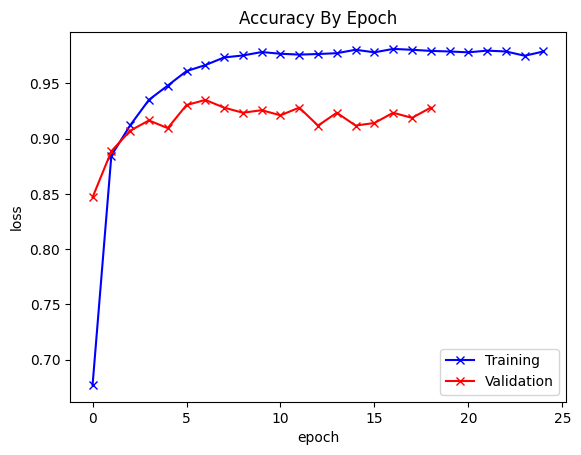

In [40]:
plot_accuracies(train_accuracy_list, valid_accuracy_list)

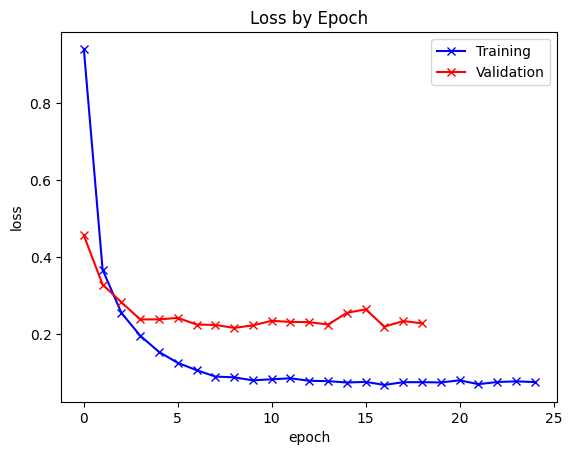

In [41]:
plot_losses(train_losses_list, valid_losses_list)

<div id="5.2" style="color:black;
   display:fill;
   border-radius:5px;
   background-color:#E5E0FF;
   font-size:12px;
   font-family:Verdana;
   letter-spacing:0.5px;
   padding:2px 2px 2px 2px;">
    <p style="font-size:18px; padding:5px 5px 5px 5px;">Model Predictions</p>
    <p>The purpose of this section is to simply showcase the performance of the trained model. Can it classify the given image properly? Some of the processes done to fulfill this objective includes:</p>
    <ul>
        <li>Define a function that is given an image, and predicts the class label </li>
        <li>Define a function that shows the input image, and displays the <u>predicted</u> class label alongside it's <u>actual</u> class label</li>
    </ul>
</div>

In [42]:
def predict_image(img, resnet50, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = resnet50(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [43]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, resnet50, df['labels'].unique())
    print('Actual Target Label:', class_labels_map[str(label)])
    print('Predicted Label from Given Image:', pred)

Actual Target Label: dandelion
Predicted Label from Given Image: dandelion


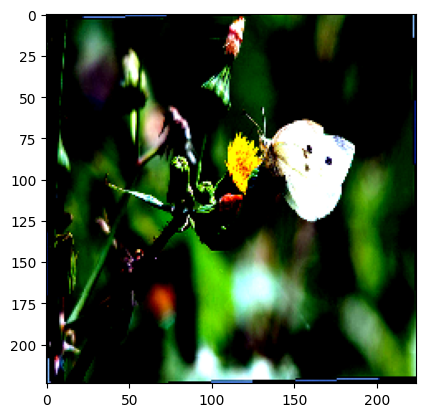

In [44]:
show_image_prediction(*valid_ds[100])

Actual Target Label: daisy
Predicted Label from Given Image: dandelion


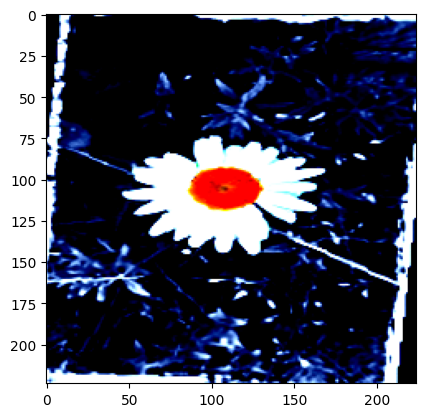

In [45]:
show_image_prediction(*valid_ds[300])

Actual Target Label: sunflower
Predicted Label from Given Image: dandelion


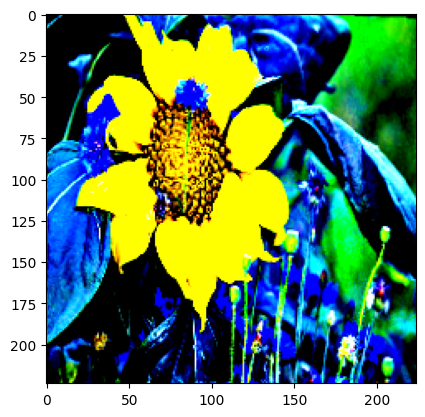

In [46]:
show_image_prediction(*valid_ds[50])

<div id="6">
    <h1>Conclusion</h1>
<p>As we reach the end of this notebook, I hope the reader understands that the processes showcased in this notebook are just the beginning. These steps are constantly iterated/modified upon throughout the entire ML training process. For example, in order to get a baseline of what the model performance is, I chose not to add too much fluff the first go-around (e.g. don't adjust anything that doesn't necessitate any adjusting...yet such as hyperparameters, freezing ResNet50 layers, etc.). The entire ML process consists of iteratively fine-tuning the hyperparameters of the model, modifying its architecture, and re-assessing what evaluation metrics are important in outlining the model's performance. So, there's plenty more I need to continually assess and adjust later on :D But for now-- here are some things that I would consider to modify to further improve the training performance! </p>
</div>
<h3>For Future Considerations</h3>

- To improve model performance, it may help to collect more data of each of the 5 flower types, hopefully enough data to make class distribution equal.
- [Order of image augmentation](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde) methods matter.
- Know why certain image augmentations are important to apply, over other ones
- Use different image transformation methods for the `validation` set, just to test how the model performs on those during evaluation phase.
- Test out what layers of the ResNet50 model I'd like to freeze, and what additional layers I'd like to add.
- Assess whether there are other hyperparameter values I can consider tuning (e.g. learning rate, optimizers)